In [1]:
# basic packages 
import numpy as np
import pandas as pd
import os
import math
import time
import ast
import time
import argparse
from matplotlib import pyplot as plt

#for AE 
#kernel = Python 3
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.nn import functional
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

import timeit

In [2]:
from scipy.sparse import csr_matrix

In [7]:
a = csr_matrix([[1,0,2],[0,3,0]])
a.todense()
a.toarray()

array([[1, 0, 2],
       [0, 3, 0]], dtype=int32)

In [3]:
#data processing
#get data based on census tract
#based on downtown Seattle
#test data
os.chdir('G:/My Drive/2021/Bias/')

test_matrice_reverse = pd.read_csv('test_matrice_reverse.csv', header=None).to_numpy()
Zero_index = pd.read_csv('Zero_index.csv', header=None).to_numpy()
#os.listsdir()

#land use data 
#obs
#obs_01
#zero index
'''
landuse_input_path = 'G:/My Drive/2021/Bias/census_block_data/'
land_use_obs = pd.read_csv('obs_landuse.csv', header=None).to_numpy()
land_use_01 =  pd.read_csv('obs01_landuse.csv', header=None).to_numpy()

land_use_zero_index = pd.read_csv('zero_index_landuse.csv',header=None).to_numpy()'''

"\nlanduse_input_path = 'G:/My Drive/2021/Bias/census_block_data/'\nland_use_obs = pd.read_csv('obs_landuse.csv', header=None).to_numpy()\nland_use_01 =  pd.read_csv('obs01_landuse.csv', header=None).to_numpy()\n\nland_use_zero_index = pd.read_csv('zero_index_landuse.csv',header=None).to_numpy()"

In [4]:
np.count_nonzero(test_matrice_reverse)

120127

In [5]:
#post data processing
#made zero matrix 
#Functions
#for the ods at the same location
#the other location at the same time should be 0
#time_diff <= 10 min

#for the ods at different location
#the other location which not belongs to the route or neatby od should be 0
#time_diff <= 20 min

#get 0 value

#besides,if appears in one place already, the location will not appear in the other census tract
def extract_od(dt, sameod = True):
    if sameod == True:
        test_dt = dt[(dt['od_euqal']==1) & (dt['time_diff']<=10)]
    else:
        test_dt = dt[(dt['od_euqal']==0) & (dt['time_diff']<=20)]
    return(test_dt)

def convert2stid(hr, minut_5, census):
    return(str(census)+'_'+str(hr)+'_'+str(minut_5))

def process_dt4convert(shr, ehr, smin, emin):
    if ehr-shr<0:
        print('data error')
        return(None)
    if ehr-shr == 0:
        if emin-smin == 0:
            return([shr], [smin])
        elif emin-smin <0:
            print('data error')
            return(None)
        else:
            interval = int((emin-smin)/5)
            min_lst = [smin]
            hr_lst = [shr]
            if interval > 1:
                for i in range(interval):
                    min_lst.append(int(smin+5*(i+1)))
                    hr_lst.append(shr)
            else:
                min_lst.append(emin)
                hr_lst.append(shr)
            return(hr_lst, min_lst)
    else:
        if emin+60-smin == 0:
            return([shr], [smin]) 
        else:
            interval = int((emin+60-smin)/5)    
            hr_lst = [shr]
            min_lst = [smin]
            if interval > 1:
                for i in range(interval):
                    if smin+(i+1)*5 >= 60:
                        min_lst.append(smin+(i+1)*5-60)
                        hr_lst.append(ehr)
                    else:
                        min_lst.append(smin+(i+1)*5)
                        hr_lst.append(shr)
            else:             
                min_lst.append(emin)
                hr_lst.append(ehr)
            return(hr_lst, min_lst) 
        
def add_zero_loc(shr, ehr, s5min, e5min, nocrossedcts, zero_loclst):
    for i in range(len(shr)):
        hr, minut = process_dt4convert(shr[i], ehr[i], s5min[i], e5min[i])
        for j in nocrossedcts[i]:
            for k in range(len(hr)):
                loc_timeids = convert2stid(hr[k], minut[k], j)
                if loc_timeids not in zero_loclst:
                    zero_loclst.append(loc_timeids)
    return(zero_loclst)

def get_nocrossed_stids(dt, zero_loc_time):
    dt = dt.sort_values(by=['newid'])
    newids = np.unique(dt['newid'])
    
    for ids in newids:
        if ids not in zero_loc_time:
            zero_loc_time[ids] = []
        #get start and end hr
        s_hr = list(dt['s_hr'][dt['newid']==ids].values)
        e_hr = list(dt['e_hr'][dt['newid']==ids].values)
        s_5min = list(dt['s_minut_5'][dt['newid']==ids].values)
        e_5min = list(dt['e_minut_5'][dt['newid']==ids].values)
        no_crossed_cts = list(dt['no_crossedcts'][dt['newid']==ids].values)
        
        zero_loc_time[ids] = add_zero_loc(s_hr, e_hr, s_5min, e_5min, no_crossed_cts, zero_loc_time[ids])
    return(zero_loc_time)

def getzero_info(dt):
    zero_loc_time = {}
    dt1 = extract_od(dt, sameod = True)
    dt2 = extract_od(dt, sameod = False)
    zero_loc_time = get_nocrossed_stids(dt1, zero_loc_time)
    zero_loc_time = get_nocrossed_stids(dt2, zero_loc_time)
    return(zero_loc_time)

def get_revised_matrix(pred_matrix, zero_loc_time):
    for ids in zero_loc_time:
        for loct_time in zero_loc_time[ids]:
            pred_matrix[newids_map[ids]][locts_map[loct_time]] = 0
    return(pred_matrix)

def convert_missingids(time_lst, ids, time_spatial_ids, Seattle_latlon, location_ids):
    for t in time_lst:
        hr = (Seattle_latlon['hr'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        minut = (Seattle_latlon['minut_5'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geoid = (Seattle_latlon[location_ids][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        newgeo = (Seattle_latlon['new_geos'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geos = list(np.unique([geoid, newgeo]))
        if 0 in geos:
            geos.remove(0)
        #get no observed census_t
        diff_ct = list(set(census_t) ^ set(geos))
        for geo_id in diff_ct:
            time_spatial_id = convert2stid(hr, minut, geo_id)
            if time_spatial_id not in time_spatial_ids:
                time_spatial_ids.append(time_spatial_id)
    return(time_spatial_ids)

def read_dict(filepath):
    with open(filepath) as f:
        data = f.read()
    dict_data = ast.literal_eval(data)
    return(dict_data)

def convert_dict(index_dict):
    convertdict = {}
    for keys in index_dict:
        convertdict[index_dict[keys]] = keys
    return(convertdict)

def save_matrix2file(input_path, savedname, input_matrix):
    np.savetxt(input_path+savedname, input_matrix, delimiter=",")

## Model-Autoencoder (AE)

[Source](https://colab.research.google.com/drive/16cI2CJg-dbdxp4FdP5IPYuaLkY5Sf_2l#scrollTo=l1fH9fv9yVfg)\
[Code Source](https://github.com/davidberger2785/RS-Workshop)

In general, auto-encoders are a class of neural networks that allow unsupervised learning of the latent characteristics of the data being studied. To do this, the AE will attempt to predict, or copy, the input observations using (multiple) hidden layer. In its simplest form, the architecture of an AE can be summarized in the diagram below.

![title](https://github.com/davidberger2785/RS-Workshop/blob/master/Images/AE.png?raw=1)

Looking more closely, the AE consists of an encoder, the function $h(\cdot)$ defined by:

$$
\begin{align}
    h(\mathbf{x}) = \frac{1}{1+ \exp(-\mathbf{W} \mathbf{x})}.
\end{align}
$$

This function takes as input the observations and will consist of recoding it as a hidden layer so as to reduce their size (fewer neurons). Afterwards, an encoder defined by:

$$
\begin{align}
    f(h(\mathbf{x})) = \mathbf{W}^\top h(\mathbf{x})
\end{align}
$$

will attempt <i>to reconstruct </i> the input observations from the hidden layer. In this sense, the AE tries to estimate the observations used as input.

We can advantageously use the estimates made by the auto-encoders in such a way as to present new recommendations to the users.

For example, suppose that the set of evaluations made by a user is defined by the vector:

$$
\begin{align}
    \mathbf{x} = [3, \ 0, \ 0, \ 1, \ ..., \ 2, \ 4].
\end{align}
$$

We note that the movie in first place, <i> Toy Story </i>, was moderately appreciated, while the following two movies, <i> Golden eye </i> and <i> Four rooms </i >, have not been viewed. Suppose once again that in this same set of assessments, the EA will present the following estimates:

$$
\begin{align}
    \mathbf{\hat{x}} = [3.2, \ 1.3, \ 4, \ 0.5, \ ..., \ 3, \ 1].
\end{align}
$$

As a result, we will be able to use the estimates associated with initially unvisited movies as recommendations. Thus, the movie <i> Four rooms </i>, in third position, seems a good suggestion for the user, while <i> Golden eye </i> is definitely not a convincing recommendation.

#### Loss function

As we saw in the previous workshop, the loss function plays an important role in the construction of a predictive model. In fact, it is this same loss function that we try to minimize (or maximize is according to) by iteratively adjusting the weights of the AE. Thus, two different loss functions will most likely result in two different models. As usual, Pytorch offers a large amount of <a href="http://pytorch.org/docs/master/nn.html#id42">loss functions</a> that you can explore at your leisure.

Since ratings vary between 1 and 5, the mean square error (MSE) seems an interesting first option. Formally, as part of a recommendation system, we will define the MSE as follows:

$$
\begin{align}
\textit{MSE}(\mathbf{R}, \hat{\mathbf{R}}) = \frac{1}{n} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2, 
\end{align}
$$

where $\mathbf{R}$ and $\hat{\mathbf{R}} $ are respectively the matrices of the observed and predicted ratings and $n$ is the number of estimates. In the same way, $r_{ui}$ and $\hat{r}_{ui} $ are scalars associated respectively with the observed evaluation and the estimate of the user $u$ for the item $i$.

Since we have encoded the loss function as an attribute of the autoencoder class, we define it with the following command.

In [ ]:
#possible issues of this method
#the test dataset covers train, test data
#however, we don't have the ground true (i.e., test data)
#one possible way to test is to check the zero index
#Sources: https://github.com/davidberger2785/RS-Workshop

In [6]:
class AE(nn.Module):
    def __init__(self, inputs, outputs, features, criterion=None):
        """
        Args: 
           self: class name
           nb_inputs: number of neurons on the input layer
           nb_outputs: number of neurons on the output layer
           nb_features: number of neurons on the hidden layer
           criterion: loss function used for learning  
        """
        
        super(AE, self).__init__()
        self.fc1 = nn.Linear(inputs, features)
        self.fc2 = nn.Linear(features, outputs)
        
        self.criterion = criterion

In [7]:
def split(data, ratio, tensor=False):
    dt = data.copy()
    #since the data matrix covers id
    dt = dt[:, 1:]
    train = np.zeros(dt.shape).tolist()
    valid = np.zeros(dt.shape).tolist()
    
    row, col = dt.shape
    for i in range(row):
        for j in range(col):
            if dt[i][j] > 0:
                if np.random.binomial(1, ratio, 1):
                    train[i][j] = dt[i][j]
                else:
                    valid[i][j] = dt[i][j]

    return [train, valid]

        
def forward(model, x):
    """
    Args:
        model: name of the autoencoder as initialized
        x: input layer, here made up of 1682 neurons
    Return:
        predictions: output layer
    """
    
    h1 = torch.sigmoid(model.fc1(x))
    return ae.fc2(h1)

def fit(model, x, y, valid=False):
    
    nb_obs, nb_items = len(x), len(x[0])
    average_loss, s = 0, 0.

    for id_user in range(nb_obs):

        inputs = Variable(x[id_user]).unsqueeze(0)
        target = Variable(y[id_user]).unsqueeze(0)

        if torch.sum(target > 0) > 0:
            
            estimate = forward(model, inputs)
            estimate[target <= 0] = 0
            target.require_grad = False
            
            loss = model.criterion(estimate, target)
            
            if not valid:
                loss.backward()
                optimizer.step()

            average_loss += loss.data / float(torch.sum(target.data > 0))
            s += 1.

    return model, average_loss, s

In [8]:
train_0 = split(test_matrice_reverse, 0.8)

In [11]:
# initialization
train = torch.FloatTensor(train_0)
train, valid = train[0], train[1]

nb_inputs = len(train[0])
nb_outputs = len(train[0])

test = test_matrice_reverse[:, 1:].copy().tolist()
test = torch.FloatTensor(test)

In [12]:
test = test_matrice_reverse[:, 1:].copy().tolist()
test = torch.FloatTensor(test)

In [ ]:
#previous hyperparameter test include
ae = AE(nb_inputs, nb_outputs, 10)
learning_rate = 0.02
weight_decay = 0.2
optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
ae.criterion = nn.MSELoss()

ae = AE(nb_inputs, nb_outputs, 10)
learning_rate = 0.02
weight_decay = 0.1
optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
ae.criterion = nn.MSELoss()

ae = AE(nb_inputs, nb_outputs, 10)
learning_rate = 0.02
weight_decay = 0.3
optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
ae.criterion = nn.MSELoss()

ae = AE(nb_inputs, nb_outputs, 10)
learning_rate = 0.01
weight_decay = 0.1
optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
ae.criterion = nn.MSELoss()

ae = AE(nb_inputs, nb_outputs, 20)
learning_rate = 0.02
weight_decay = 0.1
optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
ae.criterion = nn.MSELoss()

ae = AE(nb_inputs, nb_outputs, 15)
learning_rate = 0.02
weight_decay = 0.1
optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
ae.criterion = nn.MSELoss()

ae = AE(nb_inputs, nb_outputs, 18)
learning_rate = 0.02
weight_decay = 0.1
optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
ae.criterion = nn.MSELoss()

ae = AE(nb_inputs, nb_outputs, 18)
learning_rate = 0.02
weight_decay = 0.2
optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
ae.criterion = nn.MSELoss()

nb_epoch = 20

for epoch in range(1, nb_epoch + 1):
    ae, train_loss, train_s = fit(model=ae, x=train, y=train)
    ae, valid_loss, valid_s = fit(model=ae, x=valid, y=valid, valid=True)

    print("epoch: ", "{:3.0f}".format(epoch), "   |   train: ", "{:1.8f}".format(train_loss.numpy() / train_s), \
                    '   |   valid: ', "{:1.8f}".format(valid_loss.numpy() / valid_s))
    

In [57]:
#check input features 
for i in range(10, 36):
    print('input_features:', i)
    start = timeit.default_timer()
    ae = AE(nb_inputs, nb_outputs, i)
    learning_rate = 0.01
    weight_decay = 0.1
    optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
    ae.criterion = nn.MSELoss()

    nb_epoch = 30

    for epoch in range(1, nb_epoch + 1):
        ae, train_loss, train_s = fit(model=ae, x=train, y=train)
        ae, valid_loss, valid_s = fit(model=ae, x=valid, y=valid, valid=True)

        print("epoch: ", "{:3.0f}".format(epoch), "   |   train: ", "{:1.8f}".format(train_loss.numpy() / train_s), \
                        '   |   valid: ', "{:1.8f}".format(valid_loss.numpy() / valid_s))

    stop = timeit.default_timer()
    print('run time:', stop-start)

    ae, test_loss, test_s = fit(model=ae, x=test, y=test, valid=True)
    print('test: ',"{:1.8f}".format(test_loss.numpy() / test_s))

input_features: 10
epoch:    1    |   train:  0.00735939    |   valid:  0.00590435
epoch:    2    |   train:  0.00665492    |   valid:  0.00581273
epoch:    3    |   train:  0.00648286    |   valid:  0.00584369
epoch:    4    |   train:  0.00632533    |   valid:  0.00585202
epoch:    5    |   train:  0.00612857    |   valid:  0.00579517
epoch:    6    |   train:  0.00590494    |   valid:  0.00573204
epoch:    7    |   train:  0.00565900    |   valid:  0.00565201
epoch:    8    |   train:  0.00538554    |   valid:  0.00558794
epoch:    9    |   train:  0.00512796    |   valid:  0.00549163
epoch:   10    |   train:  0.00486895    |   valid:  0.00542668
epoch:   11    |   train:  0.00462434    |   valid:  0.00535597
epoch:   12    |   train:  0.00440330    |   valid:  0.00529489
epoch:   13    |   train:  0.00418290    |   valid:  0.00523914
epoch:   14    |   train:  0.00399679    |   valid:  0.00518108
epoch:   15    |   train:  0.00380848    |   valid:  0.00514045
epoch:   16    |   tr

epoch:    5    |   train:  0.00577585    |   valid:  0.00564519
epoch:    6    |   train:  0.00544002    |   valid:  0.00555422
epoch:    7    |   train:  0.00505656    |   valid:  0.00544623
epoch:    8    |   train:  0.00468214    |   valid:  0.00533758
epoch:    9    |   train:  0.00435328    |   valid:  0.00525410
epoch:   10    |   train:  0.00403880    |   valid:  0.00517228
epoch:   11    |   train:  0.00376819    |   valid:  0.00511070
epoch:   12    |   train:  0.00355936    |   valid:  0.00506270
epoch:   13    |   train:  0.00336064    |   valid:  0.00501164
epoch:   14    |   train:  0.00318159    |   valid:  0.00497547
epoch:   15    |   train:  0.00300791    |   valid:  0.00493518
epoch:   16    |   train:  0.00284558    |   valid:  0.00488535
epoch:   17    |   train:  0.00272973    |   valid:  0.00486264
epoch:   18    |   train:  0.00259116    |   valid:  0.00482193
epoch:   19    |   train:  0.00246049    |   valid:  0.00478945
epoch:   20    |   train:  0.00236159   

epoch:    9    |   train:  0.00396493    |   valid:  0.00514398
epoch:   10    |   train:  0.00365339    |   valid:  0.00506262
epoch:   11    |   train:  0.00339602    |   valid:  0.00499819
epoch:   12    |   train:  0.00315910    |   valid:  0.00494159
epoch:   13    |   train:  0.00296406    |   valid:  0.00489219
epoch:   14    |   train:  0.00277429    |   valid:  0.00483551
epoch:   15    |   train:  0.00260558    |   valid:  0.00479628
epoch:   16    |   train:  0.00245917    |   valid:  0.00475121
epoch:   17    |   train:  0.00232326    |   valid:  0.00472356
epoch:   18    |   train:  0.00222021    |   valid:  0.00468033
epoch:   19    |   train:  0.00212231    |   valid:  0.00464590
epoch:   20    |   train:  0.00202801    |   valid:  0.00462136
epoch:   21    |   train:  0.00194197    |   valid:  0.00459747
epoch:   22    |   train:  0.00187151    |   valid:  0.00456627
epoch:   23    |   train:  0.00179290    |   valid:  0.00453562
epoch:   24    |   train:  0.00170981   

epoch:   13    |   train:  0.00255454    |   valid:  0.00472567
epoch:   14    |   train:  0.00236767    |   valid:  0.00467311
epoch:   15    |   train:  0.00221507    |   valid:  0.00462790
epoch:   16    |   train:  0.00208726    |   valid:  0.00458887
epoch:   17    |   train:  0.00195714    |   valid:  0.00455146
epoch:   18    |   train:  0.00184058    |   valid:  0.00451258
epoch:   19    |   train:  0.00175628    |   valid:  0.00449148
epoch:   20    |   train:  0.00165771    |   valid:  0.00446186
epoch:   21    |   train:  0.00158251    |   valid:  0.00443560
epoch:   22    |   train:  0.00151256    |   valid:  0.00441050
epoch:   23    |   train:  0.00144050    |   valid:  0.00438258
epoch:   24    |   train:  0.00139150    |   valid:  0.00436078
epoch:   25    |   train:  0.00132439    |   valid:  0.00433949
epoch:   26    |   train:  0.00127432    |   valid:  0.00433170
epoch:   27    |   train:  0.00122687    |   valid:  0.00430289
epoch:   28    |   train:  0.00119373   

epoch:   17    |   train:  0.00165339    |   valid:  0.00448123
epoch:   18    |   train:  0.00156218    |   valid:  0.00445702
epoch:   19    |   train:  0.00148530    |   valid:  0.00443147
epoch:   20    |   train:  0.00141236    |   valid:  0.00440516
epoch:   21    |   train:  0.00133994    |   valid:  0.00438172
epoch:   22    |   train:  0.00129360    |   valid:  0.00435170
epoch:   23    |   train:  0.00122215    |   valid:  0.00432903
epoch:   24    |   train:  0.00117501    |   valid:  0.00430586
epoch:   25    |   train:  0.00112106    |   valid:  0.00428504
epoch:   26    |   train:  0.00107587    |   valid:  0.00426979
epoch:   27    |   train:  0.00102355    |   valid:  0.00424811
epoch:   28    |   train:  0.00098542    |   valid:  0.00423282
epoch:   29    |   train:  0.00094292    |   valid:  0.00421428
epoch:   30    |   train:  0.00090612    |   valid:  0.00420223
run time: 1067.7671113000251
test:  0.00205738
input_features: 27
epoch:    1    |   train:  0.00718504 

epoch:   21    |   train:  0.00120766    |   valid:  0.00433173
epoch:   22    |   train:  0.00115493    |   valid:  0.00432264
epoch:   23    |   train:  0.00111544    |   valid:  0.00428866
epoch:   24    |   train:  0.00106458    |   valid:  0.00428716
epoch:   25    |   train:  0.00103057    |   valid:  0.00425956
epoch:   26    |   train:  0.00099121    |   valid:  0.00425266
epoch:   27    |   train:  0.00095676    |   valid:  0.00422756
epoch:   28    |   train:  0.00092294    |   valid:  0.00421754
epoch:   29    |   train:  0.00088117    |   valid:  0.00419358
epoch:   30    |   train:  0.00084145    |   valid:  0.00418437
run time: 6456.92212969996
test:  0.00201486
input_features: 31
epoch:    1    |   train:  0.00717564    |   valid:  0.00588959
epoch:    2    |   train:  0.00652922    |   valid:  0.00584090
epoch:    3    |   train:  0.00595174    |   valid:  0.00563026
epoch:    4    |   train:  0.00528544    |   valid:  0.00546073
epoch:    5    |   train:  0.00462529   

epoch:   25    |   train:  0.00090908    |   valid:  0.00427256
epoch:   26    |   train:  0.00087269    |   valid:  0.00426131
epoch:   27    |   train:  0.00082796    |   valid:  0.00423337
epoch:   28    |   train:  0.00081453    |   valid:  0.00424206
epoch:   29    |   train:  0.00078833    |   valid:  0.00421831
epoch:   30    |   train:  0.00076062    |   valid:  0.00421114
run time: 1314.5879901000299
test:  0.00195208
input_features: 35
epoch:    1    |   train:  0.00716928    |   valid:  0.00589842
epoch:    2    |   train:  0.00650933    |   valid:  0.00581542
epoch:    3    |   train:  0.00587779    |   valid:  0.00563081
epoch:    4    |   train:  0.00518648    |   valid:  0.00544429
epoch:    5    |   train:  0.00447159    |   valid:  0.00525670
epoch:    6    |   train:  0.00384755    |   valid:  0.00510789
epoch:    7    |   train:  0.00332668    |   valid:  0.00497107
epoch:    8    |   train:  0.00293662    |   valid:  0.00486386
epoch:    9    |   train:  0.00259140 

In [14]:
i =35
print('input_features:', i)
start = timeit.default_timer()
ae = AE(nb_inputs, nb_outputs, i)
learning_rate = 0.01
weight_decay = 0.1
optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)
ae.criterion = nn.MSELoss()

nb_epoch = 30

for epoch in range(1, nb_epoch + 1):
    ae, train_loss, train_s = fit(model=ae, x=train, y=train)
    ae, valid_loss, valid_s = fit(model=ae, x=valid, y=valid, valid=True)

    print("epoch: ", "{:3.0f}".format(epoch), "   |   train: ", "{:1.8f}".format(train_loss.numpy() / train_s), \
                    '   |   valid: ', "{:1.8f}".format(valid_loss.numpy() / valid_s))

stop = timeit.default_timer()
print('run time:', stop-start)

ae, test_loss, test_s = fit(model=ae, x=test, y=test, valid=True)
print('test: ',"{:1.8f}".format(test_loss.numpy() / test_s))
    

input_features: 35
epoch:    1    |   train:  0.00746239    |   valid:  0.00484377
epoch:    2    |   train:  0.00677463    |   valid:  0.00480537
epoch:    3    |   train:  0.00608932    |   valid:  0.00471043
epoch:    4    |   train:  0.00530351    |   valid:  0.00452954
epoch:    5    |   train:  0.00455928    |   valid:  0.00438284
epoch:    6    |   train:  0.00390538    |   valid:  0.00427674
epoch:    7    |   train:  0.00335897    |   valid:  0.00420739
epoch:    8    |   train:  0.00292239    |   valid:  0.00414099
epoch:    9    |   train:  0.00257395    |   valid:  0.00410186
epoch:   10    |   train:  0.00229418    |   valid:  0.00405087
epoch:   11    |   train:  0.00207107    |   valid:  0.00400526
epoch:   12    |   train:  0.00188730    |   valid:  0.00397885
epoch:   13    |   train:  0.00173995    |   valid:  0.00394830
epoch:   14    |   train:  0.00161751    |   valid:  0.00393081
epoch:   15    |   train:  0.00150198    |   valid:  0.00390152
epoch:   16    |   tr

In [ ]:
#input feature =35
#epoch = 30, weight_decay=0.1, learning_rate=0.01
print('test: ',"{:1.8f}".format(test_loss.numpy() / test_s))

In [15]:
hidden = torch.sigmoid(ae.fc1(train)).detach().numpy()

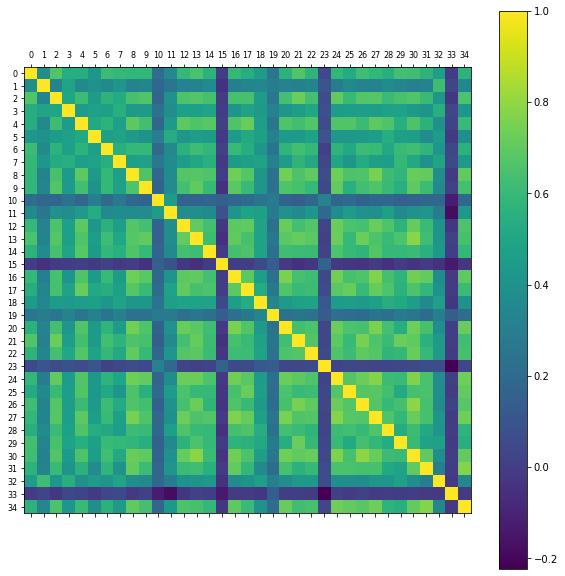

In [16]:
#exploring the correlations between different neurons
df = pd.DataFrame(np.array(hidden))
f = plt.figure(figsize=(10, 10))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=8, rotation=0)
plt.yticks(range(df.shape[1]), df.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [17]:
def fit(model, x, y, valid=False):
    
    nb_obs, nb_items = len(x), len(x[0])
    average_loss, s = 0, 0.

    for id_user in range(nb_obs):

        inputs = Variable(x[id_user]).unsqueeze(0)
        target = Variable(y[id_user]).unsqueeze(0)

        if torch.sum(target > 0) > 0:
            
            estimate = forward(model, inputs)
            estimate[target <= 0] = 0
            target.require_grad = False
            
            loss = model.criterion(estimate, target)
            
            if not valid:
                loss.backward()
                optimizer.step()

            average_loss += loss.data / float(torch.sum(target.data > 0))
            s += 1.

    return model, average_loss, s

In [18]:
def get_est(model, data, input_f, k):
    """
     Args:
         model: name of the autoencoder as initialized
         data: assessments associated with the user
         titles: list of titles of potentially recommended objects
         k: number of recommendations wanted
     Return:
         names: names of the recommendations
         scores: the score associated with them
     """
    nb_obs, nb_items = len(), len([0])
    for i in range()
    inputs = Variable(data).unsqueeze(0)
    outputs = forward(model, inputs)
    outputs[inputs != 0] = 0
    
    names, scores = utl.rearrange(titles, outputs[0].detach().numpy())
    
    return names[-k:], scores[-k:]

SyntaxError: invalid syntax (3657990070.py, line 13)

In [170]:
inputs = Variable(train+valid+test)[0]
torch.unique(inputs)


tensor([0., 2., 4., 6.])

In [172]:
torch.unique(test[0])

tensor([0., 1., 2., 3.])

In [84]:
help(Variable)

Help on class Variable in module torch.autograd.variable:

class Variable(torch._C._LegacyVariableBase)
 |  # mypy doesn't understand torch._six.with_metaclass
 |  
 |  Method resolution order:
 |      Variable
 |      torch._C._LegacyVariableBase
 |      builtins.object
 |  
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods inherited from torch._C._LegacyVariableBase:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [83]:
outputs

tensor([1.1335, 1.1812, 0.9569,  ..., 1.9046, 1.1285, 1.0608],
       grad_fn=<AddBackward0>)

In [21]:
user_id = 0
k = 30
names, scores = recommendations(ae, (train + valid + test)[user_id], movies['Title'], k)

df = pd.DataFrame(np.matrix((names[-k:], scores[-k:])).T, (np.arange(k) + 1).tolist())
df.columns = ['Title', 'Predicted rating']
df

NameError: name 'utl' is not defined

In [75]:
train[0]

3456

In [15]:
#keras model
#calculate sparsity
def get_sparsity(test_matrice):
    n_user, n_item = test_matrice.shape
    sparsity = 1 - (np.count_nonzero(test_matrice))/(n_user*n_item)
    print('data sparsity=', sparsity)
    
def get_data(user_t_data_path, test_matrice):
    #with open('user_tsinfo.txt') as f:
    with open(user_t_data_path) as f:
        infos = f.readlines()
    
    n_user, n_item = test_matrice[:, 1:].shape
    user_ids = infos[1].split(',')
    item_ids = infos[0].split(',')
    user_ids = user_ids[:-1]
    item_ids = item_ids[:-1]

    test_dt_obs = test_matrice[:,1:].flatten('F')
    test_dt_users = np.tile(user_ids, n_item)
    test_dt_items = np.repeat(item_ids, n_user)

    test_dt = pd.DataFrame(test_dt_users, columns=['userID'])
    test_dt['item'] = test_dt_items
    test_dt['obs'] = test_dt_obs
    
    return(test_dt, user_ids, item_ids)

test_sparse = get_sparsity(test_matrice_reverse[:, 1:])

'''
test_dt, user_ids, item_ids = get_data('user_tsinfo.txt', test_matrice_reverse)
test_dt_non_zero = test_dt[test_dt['obs'] > 0]

#create dict to store item index
a = 1
item_index = {}
for st_ids in item_ids:
    item_index[st_ids] = a
    a += 1
    
a = 1 
user_index = {}
for ids in user_ids:
    user_index[int(ids)] = a
    a += 1
'''

latlon_shape = pd.read_csv('G:/My Drive/2020/Bias/data-processing/latlon_shape.csv')
obs_Seattle = pd.read_csv('G:/My Drive/2020/Bias/data-processing/obs_Seattle.csv')

Seattle_geos = np.unique(list(obs_Seattle['GEOID10'].values))

latlon_shape = latlon_shape[['newid', 'geoid', 'obs', 'timestamp', 'accuracy']]
latlon_shape = latlon_shape[latlon_shape['geoid'].isin(Seattle_geos)]

get_hr = lambda x: datetime.fromtimestamp(x).hour
get_min = lambda x: int(datetime.fromtimestamp(x).minute/5)*5

latlon_shape['hr_str'] = list(map(str, list(latlon_shape['timestamp'].apply(get_hr).values)))
latlon_shape['minute_str'] = list(map(str, list(latlon_shape['timestamp'].apply(get_min).values)))
latlon_shape['geoids_str'] = list(map(str, list(latlon_shape['geoid'].values)))

latlon_shape['spatial_temp_id'] = latlon_shape['geoids_str'] + '_' + latlon_shape['hr_str'] + '_' + latlon_shape['minute_str']

latlon_shape = latlon_shape[['newid','spatial_temp_id','obs','timestamp']]

data sparsity= 0.9958141400702879


In [ ]:
convert_st2index = lambda x: item_index[x]
latlon_shape['spatial_temp_id'] = latlon_shape['spatial_temp_id'].apply(convert_st2index)
convert_newid2index = lambda x: user_index[x]
latlon_shape['newid'] = latlon_shape['newid'].apply(convert_newid2index)

latlon_shape['newid'] = latlon_shape['newid'] - 1
latlon_shape['spatial_temp_id'] = latlon_shape['spatial_temp_id'] - 1

In [18]:
min_obs = min(latlon_shape['obs'])
max_obs = max(latlon_shape['obs'])

In [19]:
train, test = train_test_split(latlon_shape, test_size=0.1)

In [26]:
ROW_COUNT = train.shape[0]

In [29]:
latlon_shape.columns

Index(['Unnamed: 0', 'timestamp', 'lat', 'lon', 'accuracy', 'idtype', 'newid',
       'd', 'hr', 'minut', 'obs', 'time', 'geometry', 'index_right',
       'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geoid'],
      dtype='object')

In [33]:
EMBEDDING_SIZE = 10
NUM_USERS = latlon_shape['newid'].nunique()
NUM_MOVIES = latlon_shape['spatial_temp_id'].nunique()

In [34]:
#learning from keras
#source: https://blog.keras.io/building-autoencoders-in-keras.html
#keras model
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [35]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

C:\Users\29700\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

In [ ]:
history = model.fit([train.spatial_temp_id, train.newid],
                    train.obs, batch_size=100,
                    epochs =50, validation_data = ([test.spatial_temp_id, 
                                                    test.newid],
                                                   test.obs),
                              verbose = 1, 
                              callbacks = callbacks)

In [46]:
model.predict([np.array([10]), np.array([3])])

array([[[1.0031551]]], dtype=float32)

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

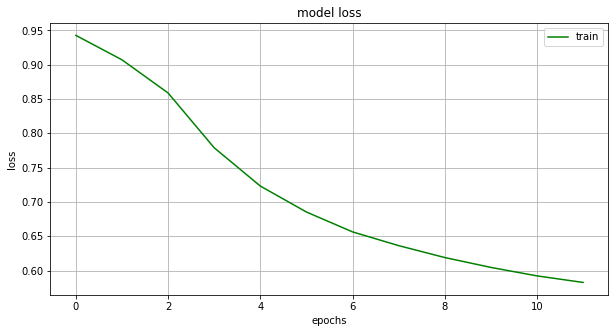

In [50]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

#### Previous Code

#land use data processing

#land use data

input_path = 'G:/My Drive/2021/Bias/census_block_data/'
os.chdir(input_path)

Seattle_land_use = pd.read_csv(input_path+'Seattle_land_use.csv')
Seattle_land_use.columns

Seattle_dt = pd.read_csv('Seattle_land_use_joined_points.csv')
Seattle_dt.head(3)

row_index = read_dict('row_index.txt')
col_index = read_dict('col_index.txt')

user_index = convert_dict(row_index)
item_index = convert_dict(col_index)

Seattle_01obs = pd.read_csv('obs01_landuse.csv', header=None).to_numpy()
Seattle_obs = pd.read_csv('obs_landuse.csv', header=None).to_numpy()

numobs_onuser = np.count_nonzero(Seattle_01obs, axis=1)
numobs_onuser_obs = np.count_nonzero(Seattle_obs, axis=1)

#data for zero index processing
latlon_file = pd.read_csv('latlon_file.csv')
col_name = latlon_file.columns
col_name

col_name = list(latlon_file.columns)
col_name.remove('Unnamed: 0')
latlon_file = latlon_file[col_name]

#latlon_file_test = pd.read_csv('Seattle_land_use_joined_points.csv')
#crossed_rt = pd.read_csv('crossed_rt.csv', index_col=0)
#crossed_rt = pd.read_csv('crossed_routes.csv')
#crossed_rt.head(3)

crossed_rt = pd.read_csv('crossed_rt.csv', index_col=0)
newids_map = row_index
locts_map = col_index
newids = list(newids_map.keys())
a = 0
index = 0
for ids in newids:
    if a <= index:
        test_dt = crossed_rt[['time_diff', 's_hr','e_hr','od_euqal']][crossed_rt['newid'] == ids]
        test_dt = test_dt.sort_values(by=['time_diff'])
        plt.figure(a)
        x = list(test_dt['s_hr'].values)
        y = list(test_dt['time_diff'].values)
        plt.plot(x,y,'o')
        plt.title('time difference between each time segement for ids = '+str(ids))
        a += 1
        
test_dt = crossed_rt[['s_hr', 'time_diff']][crossed_rt['od_euqal']==0].sort_values(by=['s_hr', 'time_diff'])
plt.figure(0)
plt.plot(list(test_dt['s_hr'].values), list(test_dt['time_diff'].values),'o')
plt.title('time difference across day')

#keep previous census tract
ori_geo = crossed_rt['ori_geo'].values
dest_geo = crossed_rt['dest_geo'].values
no_crossed_ct = crossed_rt['no_crossed_ct'].values
no_crossed_cts = []
for i in range(len(ori_geo)):
    no_crossed = no_crossed_ct[i].strip('[]').split(', ')
    if str(ori_geo[i]) in no_crossed:
        no_crossed.remove(str(ori_geo[i]))
    if str(dest_geo[i]) in no_crossed:
        no_crossed.remove(str(dest_geo[i]))
    no_crossed_cts.append(no_crossed)

del(ori_geo)
del(dest_geo)
del(no_crossed_ct)

crossed_rt['no_crossedcts'] = no_crossed_cts
crossed_rt = crossed_rt.sort_values(by=['newid','time_diff','s_hr'])

#we found missing valeues after we processing the data
#latlon_path = 'G:/My Drive/2021/Bias/data-processing/'
#Seattle_latlon = pd.read_csv('Seattle_latlon.csv', index_col=0)

selected_colname = list(latlon_file.columns)
#selected_colname.remove('Unnamed: 0.1')
to5min = lambda x: int(x/5)*5
latlon_file['minut_5'] = (latlon_file['minut'].apply(to5min)).values
#through the checking, it is found there are individuals missing after the shortest path algorithm
ids_in_dt = list(np.unique(crossed_rt['newid']))
diff = set(newids)^set(ids_in_dt)

print('# of ids with shortest path: ', len(ids_in_dt))
print('# of identified ids: ', len(newids_map.keys()))
print('# of missing ids without shortest path: ', len(diff))

#check the missed data in detail

crossed_rt = crossed_rt.sort_values(by=['newid','start_time'])
crossed_rt.reset_index(inplace=True)
crossed_rt.head(3)

newids = np.unique(crossed_rt['newid'])
kept_data_start = {}
kept_data_end = {}
for ids in newids:
    kept_data_start[ids] = list(crossed_rt['start_time'][crossed_rt['newid']==ids].values)
    kept_data_end[ids] = list(crossed_rt['end_time'][crossed_rt['newid']==ids].values)
    
#get missing trips
#missing ids with missing data
newids = np.unique(crossed_rt['newid'])
newids_all = list(newids_map.keys())
missing_ids = {}
for ids in newids_all:
    missing_ids[ids] = []
    time_data = list(latlon_file['timestamp'][latlon_file['newid']==ids].values)
    if ids not in newids:
        missing_ids[ids] = time_data
    else:    
        for time in time_data:
            if time not in kept_data_end[ids] and time not in kept_data_start[ids]:
                missing_ids[ids].append(time)
                
missing_pairs = {}
for ids in newids:
    missing_pairs[ids] = {'o':[],'d':[]}
    cur_odpairs = crossed_rt[['start_time', 'end_time']][crossed_rt['newid']==ids].values
    time_data = list(latlon_file['timestamp'][latlon_file['newid']==ids].values)
    for i in range(len(time_data)):
        if i < len(time_data)-1:
            od_pairs = []
            od_pairs.append(time_data[i]) 
            od_pairs.append(time_data[i+1])
            if od_pairs not in cur_odpairs:
                missing_pairs[ids]['o'].append(od_pairs[0])
                missing_pairs[ids]['d'].append(od_pairs[1]) 
                

                
print('worst data accuracy: ', np.max(latlon_file['accuracy']))

census_t = list(np.unique(latlon_file['ZONEID']))

zero_loc_time = {}
for ids in missing_ids:
    if ids not in zero_loc_time:
        #print(ids)
        zero_loc_time[ids] = []
    #print(missing_ids[ids])    
    zero_loc_time[ids] = convert_missingids(missing_ids[ids], ids, zero_loc_time[ids], latlon_file, 'ZONEID')

#obs data check
#count_nonzeros
index_num = 0
user_w_smallobs = []
for i in numobs_onuser:
    if i <= 1:
        user_w_smallobs.append(user_index[index_num])
    index_num += 1     
    
for i in range(len(user_w_smallobs)):
    print(np.max(Seattle_obs[row_index[user_w_smallobs[i]]]))
    
### create the zero index matrix
Zero_index = np.zeros(Seattle_01obs.shape)
for row in zero_loc_time:
    for col in zero_loc_time[row]:
        Zero_index[newids_map[row]][locts_map[col]] = 1
        
### create the zero index matrix
Zero_index = np.zeros(Seattle_01obs.shape)
for row in zero_loc_time:
    for col in zero_loc_time[row]:
        Zero_index[newids_map[row]][locts_map[col]] = 1
        
save_matrix2file('../census_block_data/','zero_land_use.csv', Zero_index)